# Encoder Only

https://github.com/neelnanda-io/TransformerLens/blob/main/demos/BERT.ipynb

In [1]:
import torch, transformer_lens, itertools
from measureLM import visualizing, decoding, patching, scoring

from transformers import AutoTokenizer
from transformer_lens import HookedEncoder

In [2]:
model = HookedEncoder.from_pretrained("bert-base-cased").to("cpu")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model.cfg.spacing = ""
model.tokenizer = tokenizer

If using BERT for interpretability research, keep in mind that BERT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model bert-base-cased into HookedTransformer
Moving model to device:  cpu


### 1) Get activations


prompt 0
layer 11: [(0.002, 'Hillary'), (0.0667, 'Obama'), (0.0588, 'George'), (0.1429, 'Trump'), (1.0, 'Joe')]


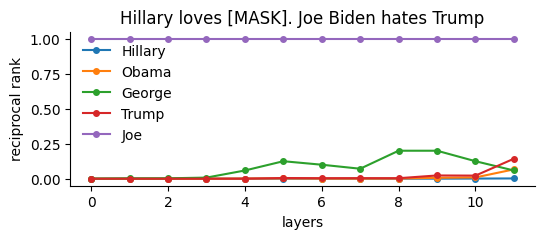

In [7]:
args = [("excellent","1"), ("awful","0"), ("bad","0")]
prompts = [f'The sentiment of "{args[0][0]}" is {args[0][1]}. The sentiment of "{args[1][0]}" is {args[1][1]}. The sentiment of "{args[2][0]}" is [MASK]']

args = [("Julia and Romeo","friends"), ("Harry Potter and Lord Voldemord","enemies"), ("Batman and the Joker","enemies")]
prompts = [f'Q: What is the relationship of {args[0][0]}? A: [MASK] Q: What is the relationship of {args[1][0]}? A: {args[1][1]} Q: What is the relationship of {args[2][0]}? A: enemies']
prompts = [f'{args[0][0]} are [MASK]']


prompts = ["Hillary loves [MASK]. Joe Biden hates Trump"]
args = [("Trump", "Joe", "Hillary", "George", "Obama")]

logits, activs, tokens = decoding.encode(prompts, model)
layer_scores = decoding.early_decoding(activs, model)

token_candidates = list(set(itertools.chain(*args)))
tok_idx = scoring.token_select(tokens, model, select_token="Joe")
scored_tokens = scoring.scores_to_tokens(layer_scores, tok_idx, model, mode=token_candidates)
visualizing.visualize_token_ranks(scored_tokens, token_candidates, prompts)

### (2) Use activations to intervene

['Joker', 'Batman', 'foil']

prompt 0
layer 11: [(1.0, 'Joker'), (0.5, 'Batman')]


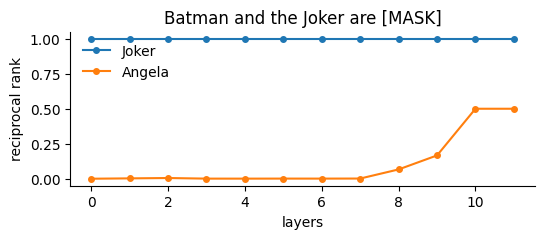

In [26]:
new_prompts = [f'{args[2][0]} are [MASK]']
new_logits, new_activs, new_tokens = decoding.encode(new_prompts, model)
insert_tok_idx = scoring.token_select(new_tokens, model, select_token="Joker")
pred = model.tokenizer.convert_ids_to_tokens(torch.topk(new_logits[insert_tok_idx], k=3).indices.tolist()[0])
print(pred)


patch_map = patching.create_hook_mapping(model, patch_l=(15, 30))
patch_logits, resid_post = patching.intervene(new_tokens, activs, model, patch_map, extract_tok_idx=tok_idx, insert_tok_idx=insert_tok_idx)
resid_layer_scores = decoding.early_decoding(resid_post, model)

new_token_candidates = token_candidates

## scoring
extract_tok_idx = scoring.token_select(new_tokens, model, select_token="Joker")
scored_tokens = scoring.scores_to_tokens(resid_layer_scores, extract_tok_idx, model, mode=["Joker", "Batman"])
visualizing.visualize_token_ranks(scored_tokens, ["Joker", "Angela"], new_prompts)


In [21]:
insert_tok_idx

(tensor([0]), tensor([4]))